In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from transformer import TransformerConfig
from lm import LM

In [2]:
# chargement des données
fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')
villes = [ville for ville in villes if len(ville) > 2]

In [3]:
# création du vocabulaire

vocabulaire = sorted(list(set(''.join(villes))))
vocabulaire = ["<pad>", "<SOS>", "<EOS>"] + vocabulaire
# <SOS> et <EOS> sont ajoutés respectivement au début et à la fin de chaque séquence
# <pad> est utilisé pour faire en sorte que toutes les séquences aient la même longueur

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [4]:
num_sequences = len(villes)
max_len = max([len(ville) for ville in villes]) + 2 # <SOS> et <EOS>

X = torch.zeros((num_sequences, max_len), dtype=torch.int32)

for i in range(num_sequences):
    X[i] = torch.tensor([char_to_int['<SOS>']] + [char_to_int[c] for c in villes[i]] + [char_to_int['<EOS>']] + [char_to_int['<pad>']] * (max_len - len(villes[i]) - 2))

n_split = int(0.9*X.shape[0])

idx_permut = torch.randperm(X.shape[0])
idx_train, _ = torch.sort(idx_permut[:n_split])
idx_val, _ = torch.sort(idx_permut[n_split:])

X_train = X[idx_train]
X_val = X[idx_val]

In [5]:
def get_batch(split, batch_size):
    data = X_train if split == 'train' else X_val

    idx_seed = torch.randint(low=int(batch_size/2), high=int(data.shape[0]-batch_size/2), size=(1,), dtype=torch.int32).item()

    batch = data[int(idx_seed-batch_size/2):int(idx_seed+batch_size/2)]
    X = batch[:, :-1] # (B, L=max_len-1=46)
    Y = batch[:, 1:] # (B, L)
    return X, Y.long()

In [61]:
class AutoEncoder(nn.Module):
    def __init__(self, act_size, d_hidden):
        super().__init__()

        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(act_size, d_hidden)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, act_size)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden))
        self.b_dec = nn.Parameter(torch.zeros(act_size))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
    
    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = 3-3 * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss
    
    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

In [186]:
config = TransformerConfig(d_model=128, n_layers=1, n_heads=4, max_len=max_len, dropout=0.)
model = LM(config, vocab_size=len(vocabulaire))
model.load_state_dict(torch.load("transformer.pth"))

sae = SAE(d_model=config.d_model, num_features=2*128)
optim = torch.optim.AdamW(sae.parameters(), lr=3e-4)

In [187]:
for i in range(1000):
    X, Y = get_batch('train', 16) # (B, L)
    #torch.norm(model(X, act=True), dim=(0, 1)).mean()**2

    act = model(X, act=True).view(-1, config.d_model) # (B*L, 128)
    features, act_recon = sae(act)

    loss = F.mse_loss(act_recon, act) + 3e-3 * torch.mean(torch.abs(features))
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i%100==0:
        print(loss.item())

0.0382436141371727
0.004968831315636635
0.0027571229729801416
0.0018517046701163054
0.0014958262909203768
0.0012416176032274961
0.0010103663662448525
0.0009283294202759862
0.0007838063174858689
0.0007059992058202624


In [188]:
X, Y = get_batch('train', 1) # (B, L)
act = model(X, act=True).view(-1, config.d_model) # (B, L, d_model)
features, act_recon = sae(act)

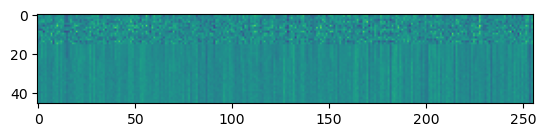

In [192]:
plt.imshow(features.detach())

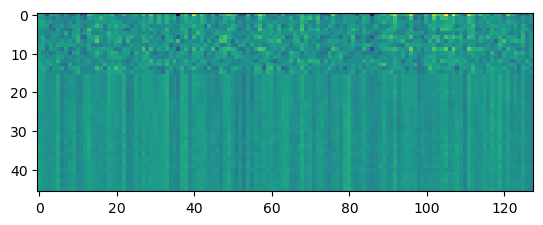

In [190]:
plt.imshow(act.detach())

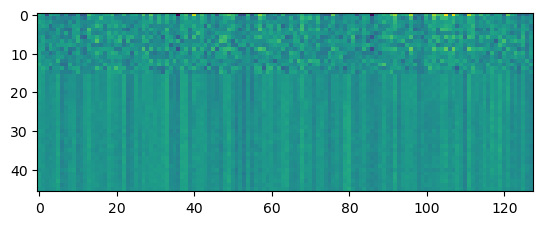

In [191]:
plt.imshow(act_recon.detach())